# Import qbiome

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis
from qbiome.qutil import customDataFormatter
from qbiome.qutil import qsmooth

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
plt.style.use('ggplot')

from qbiome.qutil import qplot

# Data and initialization

In [2]:
dirname = 'example_data/'
data = '../../infbiome_/data/HC/hc_Phylum_GTDB_denoised_filtered_percent.csv'
meta = dirname + 'hc_metadata.csv'
BIOMES=None
BIOMES=['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'Fusobacteriota']

data,property_map=customDataFormatter(data,meta,
                        META_PROP=['hc', 'HCZ', 'sex', 'hc_Birth',
           'HCZ_Birth', 'hc_Discharge', 'HCZ_Discharge',
           'HCZ_discharge_birth_difference', 'HCZ_Category',
           'HCZ_difference_Category', 'NEC', 'IVH', 'ROP', 'BPD', 'Infection',
           'total_Morbidities', 'Morbidity_Category', 'TIMPS score',
           'TIMPS z-score', 'TIMPS Category'],
                        COL_SELECT={"Samples": "sample_id", "PTID": "subject_id", "PMA":"week"},
                                      BIOMES=BIOMES)

data_=data.assign(source='gnd')
quantizer = Quantizer(num_levels=6)
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

In [3]:
data

,sample_id,variable,value,subject_id,week
0,100001.c.062,Actinobacteriota,0.000000,100001,34
1,100001.c.062,Bacteroidota,0.677740,100001,34
2,100001.c.062,Firmicutes,3.005389,100001,34
3,100001.c.062,Proteobacteria,66.657408,100001,34
4,100001.c.062,Fusobacteriota,0.000000,100001,34
...,...,...,...,...,...
665,100091.c.053,Actinobacteriota,0.619998,100091,31
666,100091.c.053,Bacteroidota,4.385075,100091,31
667,100091.c.053,Firmicutes,0.247999,100091,31
668,100091.c.053,Proteobacteria,86.190959,100091,31


In [4]:
BIOMES=list(data.variable.value_counts().index.values)
BIOMES

['Fusobacteriota',
 'Bacteroidota',
 'Actinobacteriota',
 'Firmicutes',
 'Proteobacteria']

# Train qnet

In [5]:
%%time
NUMQ=1
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator.train_qnet(
        features, label_matrix, alpha=0.3, min_samples_split=2, 
        out_fname=None)
    qnet_orchestrator.save_qnet('data1_phylum_'+str(i)+'.joblib')
    #qnet_orchestrator.load_qnet('data1.joblib')

100%|██████████| 1/1 [00:05<00:00,  5.89s/it]

CPU times: user 2.73 s, sys: 194 ms, total: 2.92 s
Wall time: 5.89 s


In [6]:
outdirname = 'dotfiles_1_phylum_'
import os
if not os.path.isdir(outdirname):
    os.makedirs(outdirname)
for f in os.listdir(outdirname):
    os.remove(os.path.join(outdirname, f))    
qnet_orchestrator.export_qnet_tree_dotfiles(outdirname)

! cd 'dotfiles_1_phylum_'; for i in `ls *dot`; do dot -Tpng $i -o ${i/dot/png}; done >& \dev\null

76


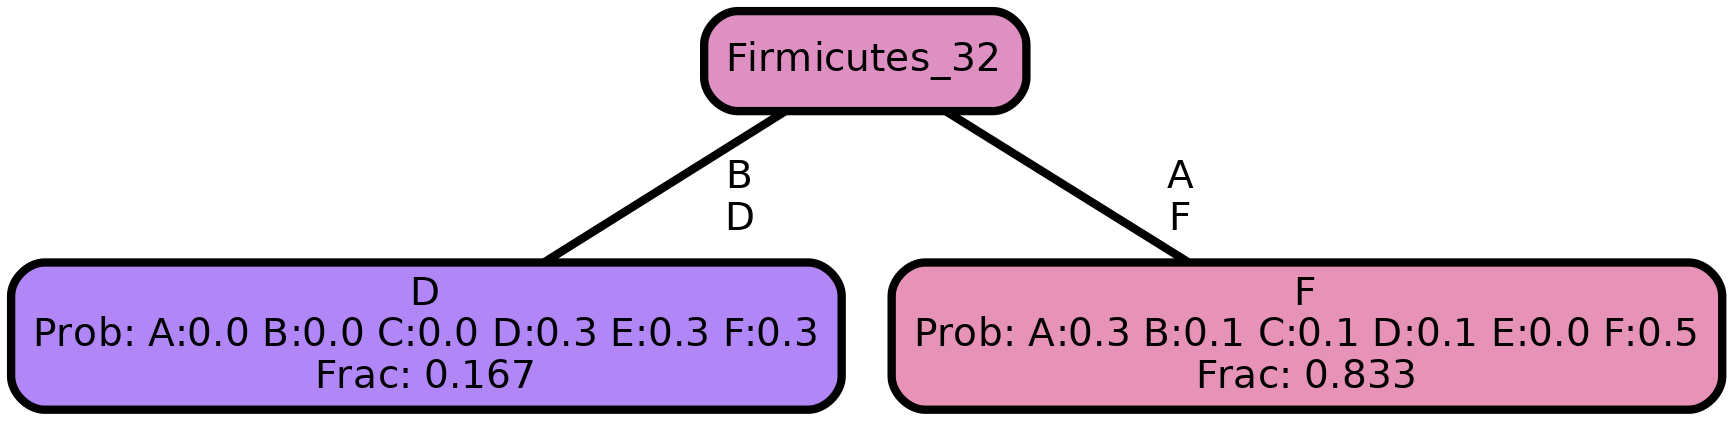

In [7]:
! ls -lhS dotfiles_1_phylum_/*png | wc -l

from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='dotfiles_1_phylum_/Proteobacteria_32.png')

In [8]:
hypothesis = Hypothesis(quantizer=quantizer, model_path=outdirname, 
                        detailed_labels=True)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=27, time_end=34)
hypothesis.to_dot('hypothesis_phylum_30_34_-2.dot')
hypothesis.hypotheses.sort_values('src')

100%|██████████| 5/5 [00:00<00:00,  5.53it/s]


,src,tgt,time_tgt,lomar,pvalue
0,Actinobacteriota,Fusobacteriota,28.0,1.083765e-02,0.000000e+00
12,Actinobacteriota,Bacteroidota,34.0,1.294382e-01,2.071893e-135
28,Actinobacteriota,Firmicutes,28.0,1.025546e+00,0.000000e+00
29,Actinobacteriota,Firmicutes,33.0,6.860619e-02,5.035883e-54
27,Actinobacteriota,Firmicutes,31.0,-5.865703e-01,0.000000e+00
30,Actinobacteriota,Firmicutes,30.0,2.160398e+00,0.000000e+00
4,Actinobacteriota,Actinobacteriota,30.0,4.184763e-01,0.000000e+00
19,Actinobacteriota,Proteobacteria,31.0,4.745384e+00,0.000000e+00
5,Bacteroidota,Actinobacteriota,30.0,4.089863e-01,0.000000e+00
6,Bacteroidota,Actinobacteriota,31.0,1.502427e-02,0.000000e+00


In [9]:
%%time
NUMQ=1
SW=25
forecasted_dict={}
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator_i = QnetOrchestrator(quantizer)
    qnet_orchestrator_i.load_qnet('data1_phylum_'+str(i)+'.joblib')
    forecaster_i = Forecaster(qnet_orchestrator_i)
    # can specify an end week or default to the max end week in the data
    forecasted_dict[i] = forecaster_i.forecast_data(
        label_matrix, 
        start_week=SW).assign(source='forecasted'+str(i))
    

100%|██████████| 1/1 [00:30<00:00, 30.64s/it]

CPU times: user 30.5 s, sys: 32.7 ms, total: 30.5 s
Wall time: 30.6 s


In [10]:
#forecasted_dict[0]
DF=pd.concat([forecasted_dict[key] for key in np.arange(NUMQ)])
SUBJECTS=DF.subject_id.value_counts().index.values
DF

,subject_id,variable,week,value,source
0,100001,Actinobacteriota,24,NaN,forecasted0
1,100002,Actinobacteriota,24,NaN,forecasted0
2,100003,Actinobacteriota,24,NaN,forecasted0
3,100004,Actinobacteriota,24,NaN,forecasted0
4,100005,Actinobacteriota,24,NaN,forecasted0
...,...,...,...,...,...
3700,100078,Proteobacteria,43,78.595107,forecasted0
3701,100083,Proteobacteria,43,78.982302,forecasted0
3702,100084,Proteobacteria,43,78.595107,forecasted0
3703,100090,Proteobacteria,43,78.982302,forecasted0


In [11]:
Q=[]
for subject_id in tqdm(SUBJECTS):
    QF=None
    for i in np.arange(NUMQ):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().Infection.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

100%|██████████| 39/39 [00:03<00:00,  9.88it/s]


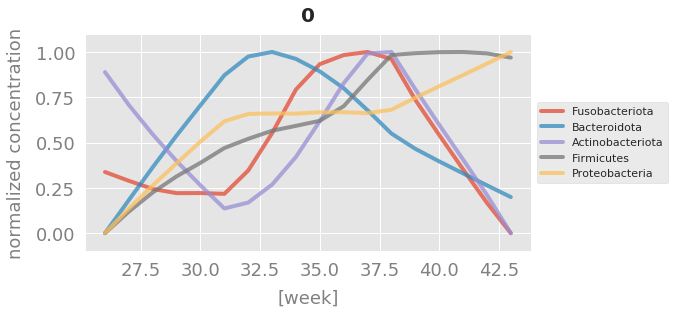

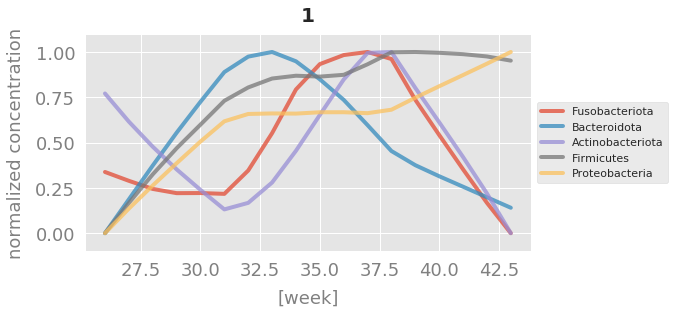

In [12]:
DD=pd.concat(Q)
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).median().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.7,save=False)

dd_os=dd[0]-dd[1]

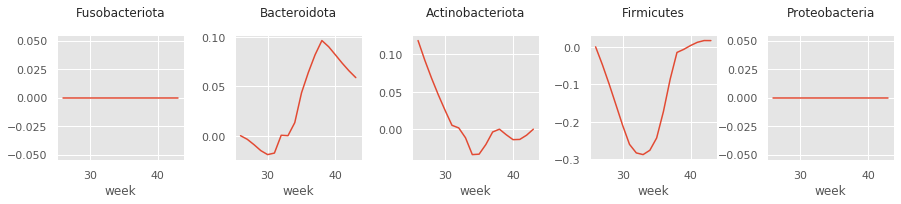

In [13]:
fig=plt.figure(figsize=[15,6])
plt.subplots_adjust(wspace=.4, hspace=.6)

count=0
C=5
R=len(BIOMES)//C+1
for i in BIOMES:
    count=count+1
    plt.subplot(R,C,count)
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ infection')
    #ax.legend()
    ax.set_title(i,fontsize=12,y=1.1)
    if count < len(BIOMES)-4:
        ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(loc='best', bbox_to_anchor=(-1,23))
#qbiome.qutil.saveFIG('infection.png',axis=True)

In [14]:
Q=[]
for subject_id in tqdm(SUBJECTS):
    QF=None
    for i in np.arange(NUMQ):
        DF_=DF[(DF.subject_id==subject_id) 
               & (DF.source=='forecasted'+str(i))] 
        #       & (DF.variable=='Actinobacteriota')]
        #display(DF_)
        qf=quantizer.apply_random_forest_regressor(DF_[DF_.week>=SW]).assign(subject_id=subject_id)
        if QF is None:
            QF=qf.drop('value',axis=1)
            QF['value_'+str(i)]=qf.value
        else:
            QF['value_'+str(i)]=qf.value
    QF=pd.DataFrame(QF.set_index(['variable','week','subject_id']).mean(axis=1),columns=['value']).reset_index()
    y=property_map[property_map.subject_id==subject_id].drop(['hc','HCZ'],axis=1).drop_duplicates().HCZ_Category.values[0]
    QF=QF.assign(phn=y)
    Q=Q+[QF]

from qbiome.qutil import qplot
DD=pd.concat(Q)

100%|██████████| 39/39 [00:04<00:00,  9.72it/s]


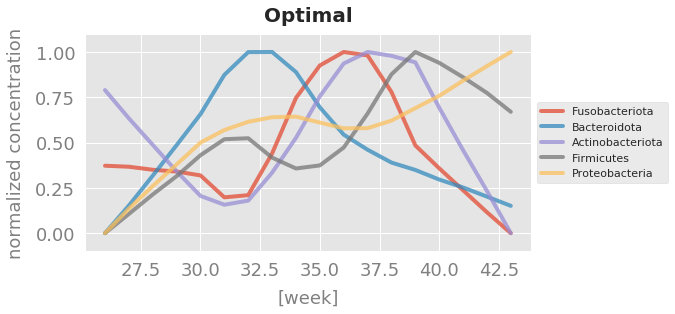

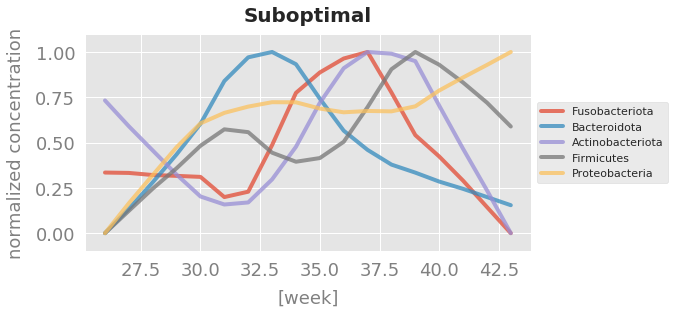

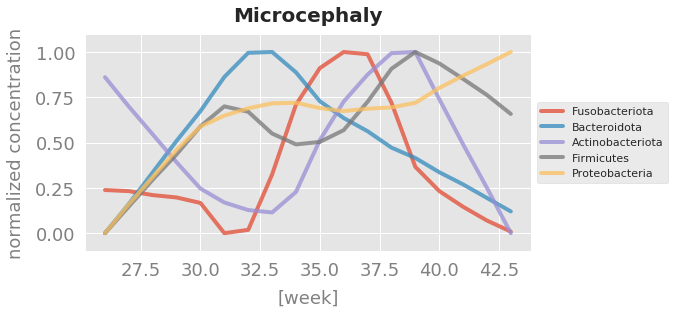

In [15]:
dd={}
for phn in DD.phn.value_counts().index.values:
    DD_=DD[DD.phn==phn]
    DD_=DD_.groupby(['week','variable']).mean().reset_index().drop(['subject_id'],axis=1)
    DD_=DD_.drop_duplicates().assign(phn=phn)
    dd[phn]=qplot(DD_,var=BIOMES,preindex='phn',index='week',columns='variable',
                   interpolate=False,normalize=True,title=phn,lowess_fraction=0.5,save=False)

dd_os=dd['Optimal']-dd['Suboptimal']
dd_om=dd['Optimal']-dd['Microcephaly']

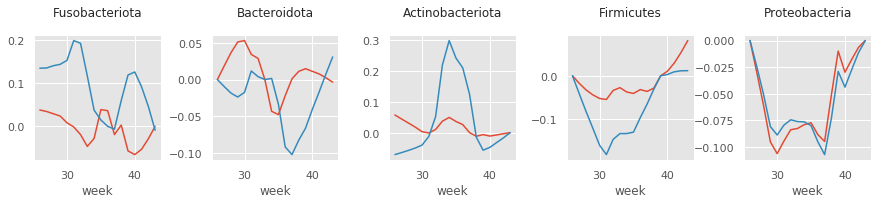

In [16]:
fig=plt.figure(figsize=[15,6])
plt.subplots_adjust(wspace=.4, hspace=.6)

count=0
C=5
R=len(BIOMES)//C+1
for i in BIOMES:
    count=count+1
    plt.subplot(R,C,count)
    ax=plt.gca()
    ax=dd_os[i].plot(ax=ax,label='$\delta$ suboptimal')
    ax=dd_om[i].plot(ax=ax,label='$\delta$ microcephaly')
    #ax.legend()
    ax.set_title(i,fontsize=12,y=1.1)
    if count < len(BIOMES)-4:
        ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
#ax.legend(loc='best', bbox_to_anchor=(-1,23))


# Use the forecaster to predict new data

We construct a new patient from the quantized data column names because it contains all the feature names that the qnet uses.

In [17]:
new_subject_id = '101'
np.random.seed(10001)
# initialize with random floats
new_patient = pd.DataFrame(
    np.random.rand(1, len(quantized.columns)),
    index=[0],
    columns=quantized.columns
)
new_patient.subject_id = new_subject_id
new_patient

,subject_id,Actinobacteriota_24,Actinobacteriota_26,Actinobacteriota_27,Actinobacteriota_28,Actinobacteriota_29,Actinobacteriota_30,Actinobacteriota_31,Actinobacteriota_32,Actinobacteriota_33,...,Proteobacteria_34,Proteobacteria_35,Proteobacteria_36,Proteobacteria_37,Proteobacteria_38,Proteobacteria_39,Proteobacteria_40,Proteobacteria_41,Proteobacteria_42,Proteobacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,0.892232,0.694006,0.900454,0.584406,0.305097,...,0.949514,0.797598,0.71139,0.612895,0.919532,0.627349,0.311821,0.825716,0.535942,0.717411


In [18]:
new_patient_seq = new_patient.drop(columns='subject_id').to_numpy().squeeze()
new_patient_seq.shape

(95,)

In [19]:
# suppose we only have 6 weeks of data for the new patient
# we mask out the remainder of the weeks
new_patient_masked = qnet_orchestrator.mask_sequence_at_weeks(
    new_patient_seq, 
    start_week=29, 
    end_week=qnet_orchestrator.get_max_timestamp(),
    fill_value=np.nan
)

In [20]:
new_patient_df = quantizer.add_meta_to_matrix(
    new_patient_masked[np.newaxis, :],
    add_subject_id=False
)
# manually add back subject_id
new_patient_df.insert(0, 'subject_id', [new_subject_id])
new_patient_df

variable,subject_id,Actinobacteriota_24,Actinobacteriota_26,Actinobacteriota_27,Actinobacteriota_28,Actinobacteriota_29,Actinobacteriota_30,Actinobacteriota_31,Actinobacteriota_32,Actinobacteriota_33,...,Proteobacteria_34,Proteobacteria_35,Proteobacteria_36,Proteobacteria_37,Proteobacteria_38,Proteobacteria_39,Proteobacteria_40,Proteobacteria_41,Proteobacteria_42,Proteobacteria_43
0,101,0.116507,0.704285,0.523539,0.1577,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
new_patient_df = quantizer.melt_into_plot_format(new_patient_df)
new_patient_df

,subject_id,variable,week,value
0,101,Actinobacteriota,24,0.116507
1,101,Actinobacteriota,26,0.704285
2,101,Actinobacteriota,27,0.523539
3,101,Actinobacteriota,28,0.157700
4,101,Actinobacteriota,29,NaN
...,...,...,...,...
90,101,Proteobacteria,39,NaN
91,101,Proteobacteria,40,NaN
92,101,Proteobacteria,41,NaN
93,101,Proteobacteria,42,NaN


In [22]:
# quantize
new_patient_quantized = quantizer.quantize_df(new_patient_df)
# convert this patient into a format acceptable by the qnet
_, new_patient_matrix = quantizer.get_qnet_inputs(new_patient_quantized)
new_patient_matrix.shape

(1, 95)

## Forecast the data starting from week 7 to the last week

In [23]:
# takes 2 minutes to run
new_patient_forecasted = forecaster_i.forecast_data(
    new_patient_matrix, 
    start_week=SW
)

In [24]:
new_patient_forecasted.head()

,subject_id,variable,week,value
0,101,Actinobacteriota,24,NaN
1,101,Actinobacteriota,26,3.786014
2,101,Actinobacteriota,27,2.998276
3,101,Actinobacteriota,28,1.451694
4,101,Actinobacteriota,29,2.123914


The NaNs are due to the random values we generated falling outside the quantization range.

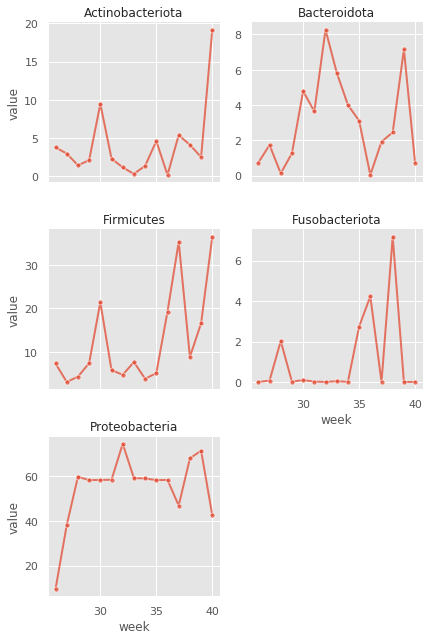

In [25]:
# zoom into the first 20 weeks
plottable = new_patient_forecasted[
    (new_patient_forecasted.variable.isin(BIOMES)) &
    (new_patient_forecasted.week <= 40)
     ]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

In [26]:
new_subject = pd.DataFrame({
    'week': [SW] * len(BIOMES),
    'variable': BIOMES,
    'value': np.random.rand(len(BIOMES))
})

new_subject

,week,variable,value
0,25,Fusobacteriota,0.385470
1,25,Bacteroidota,0.426541
2,25,Actinobacteriota,0.560328
3,25,Firmicutes,0.092690
4,25,Proteobacteria,0.635572


In [27]:
new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='101')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster_i.forecast_data(
    new_subject_matrix, 
    start_week=1
)

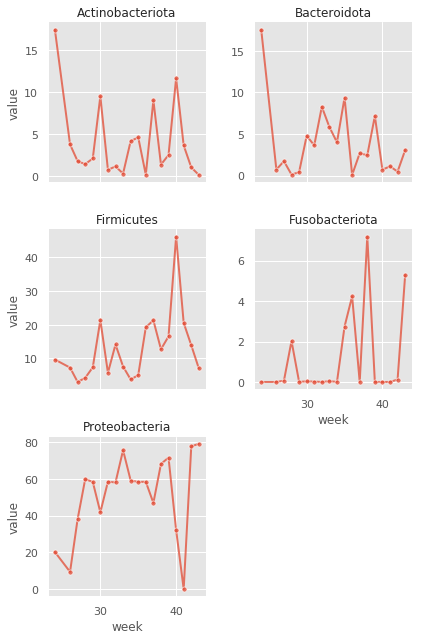

In [28]:
plottable = new_subject_forecasted[new_subject_forecasted.variable.isin(BIOMES)]

g = sns.FacetGrid(plottable, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

In [29]:
df=plottable.drop('subject_id',axis=1).pivot(index='week',columns='variable')
df.columns=[x[1] for x in df.columns]
df

,Actinobacteriota,Bacteroidota,Firmicutes,Fusobacteriota,Proteobacteria
week,,,,,
24,17.378309,17.533127,9.685795,-0.000167,20.242440
26,3.786014,0.732777,7.287059,-0.000167,9.465035
27,1.798965,1.732673,3.025896,0.064925,38.127328
28,1.451694,0.125610,4.244525,2.024117,59.790998
29,2.123914,0.417763,7.363495,0.005533,58.292894
30,9.483191,4.787242,21.419191,0.029966,41.794669
31,0.773394,3.636724,5.751005,0.018675,58.439780
32,1.181649,8.272578,14.158257,-0.000167,57.991155
33,0.334568,5.835468,7.612005,0.037674,75.510078


In [30]:
qsmooth(plottable.drop('subject_id',axis=1),index='week',columns='variable',
       interpolate=False,alpha=.9,
          lowess_fraction=0.6,normalize=False)

NameError: name 'timeunit' is not defined